<a href="https://colab.research.google.com/github/Number1e/Project-Klasifikasi-Sampah-Mata-Kuliah-Machine-Learning/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# --- 1. KONFIGURASI ---
PATH_TRAINING = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/training'
PATH_VALIDATION = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/validation'

# Ukuran gambar sedikit diperkecil untuk mempercepat training from scratch
# (opsional, bisa tetap 224 jika GPU kuat)
UKURAN_GAMBAR = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50 # Ditambah karena training from scratch butuh waktu lebih lama

In [3]:
# --- 2. MEMPERSIAPKAN DATA (DATA GENERATORS) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Augmentasi: putar gambar
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,   # Augmentasi: balik horizontal
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    PATH_TRAINING,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    PATH_VALIDATION,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # PENTING: Jangan di-shuffle agar urutan prediksi sesuai
)

# Mengambil label kelas
class_labels = list(train_generator.class_indices.keys())
JUMLAH_KELAS = len(class_labels)
print(f"Kelas ditemukan: {class_labels}")

Found 2300 images belonging to 3 classes.
Found 813 images belonging to 3 classes.
Kelas ditemukan: ['Kaca', 'Kardus', 'Plastik']


In [4]:
# --- 3. MEMBANGUN ARSITEKTUR MODEL (CNN FROM SCRATCH) ---
# Pola standar: Conv -> BatchNorm -> ReLU -> Pooling
model = Sequential([
    # Block 1: Mendeteksi fitur dasar (garis, tepi)
    Conv2D(32, (3, 3), activation='relu', input_shape=(UKURAN_GAMBAR[0], UKURAN_GAMBAR[1], 3)),
    BatchNormalization(), # Menstabilkan training
    MaxPooling2D(2, 2),

    # Block 2: Mendeteksi tekstur & bentuk sederhana
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3: Mendeteksi pola yang lebih kompleks
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 4: Deep features
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Classifier Head
    GlobalAveragePooling2D(), # Menggantikan Flatten (lebih efisien parameter)
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout tinggi (50%) sangat penting untuk model from scratch
    Dense(JUMLAH_KELAS, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# --- 4. KOMPILASI MODEL ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # Learning rate sedikit lebih kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,459 (2.00 MB)

 Trainable params: 522,499 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [6]:
# --- 5. MELATIH MODEL ---
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_sampah_scratch.h5', monitor='val_accuracy', save_best_only=True)

print("Mulai melatih model CNN From Scratch...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)

Mulai melatih model CNN From Scratch...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5469 - loss: 1.0196

71/71 ━━━━━━━━━━━━━━━━━━━━ 628s 9s/step - accuracy: 0.5477 - loss: 1.0183 - val_accuracy: 0.2988 - val_loss: 1.1067
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 7:32 6s/step - accuracy: 0.6875 - loss: 0.7933

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 447ms/step - accuracy: 0.6875 - loss: 0.7933 - val_accuracy: 0.3050 - val_loss: 1.1088
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6516 - loss: 0.8122

71/71 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - accuracy: 0.6518 - loss: 0.8120 - val_accuracy: 0.4100 - val_loss: 1.1677
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 482ms/step - accuracy: 0.6875 - loss: 0.6174 - val_accuracy: 0.3988 - val_loss: 1.1730
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6694 - loss: 0.7694

71/71 ━━━━━━━━━━━━━━━━━━━━ 504s 7s/step - accuracy: 0.6695 - loss: 0.7692 - val_accuracy: 0.4563 - val_loss: 1.0054
Epoch 6/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 5:47 5s/step - accuracy: 0.7188 - loss: 0.6995

71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 548ms/step - accuracy: 0.7188 - loss: 0.6995 - val_accuracy: 0.4688 - val_loss: 1.0022
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7078 - loss: 0.6948

71/71 ━━━━━━━━━━━━━━━━━━━━ 494s 7s/step - accuracy: 0.7079 - loss: 0.6948 - val_accuracy: 0.4737 - val_loss: 0.9927
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.5625 - loss: 0.9227 - val_accuracy: 0.4350 - val_loss: 1.0236
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.7248 - loss: 0.6420 - val_accuracy: 0.3787 - val_loss: 1.1750
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.7500 - loss: 0.7497 - val_accuracy: 0.3762 - val_loss: 1.1834
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7186 - loss: 0.6665

71/71 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.7186 - loss: 0.6664 - val_accuracy: 0.7063 - val_loss: 0.6778
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 438ms/step - accuracy: 0.7500 - loss: 0.5879 - val_accuracy: 0.6963 - val_loss: 0.6890
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.7195 - loss: 0.6605 - val_accuracy: 0.5475 - val_loss: 0.9501
Epoch 14/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 512ms/step - accuracy: 0.8438 - loss: 0.4733 - val_accuracy: 0.5213 - val_loss: 0.9927
Epoch 15/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 480s 6s/step - accuracy: 0.7311 - loss: 0.6181 - val_accuracy: 0.5450 - val_loss: 1.0208
Epoch 16/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 501ms/step - accuracy: 0.8750 - loss: 0.5608 - val_accuracy: 0.5275 - val_loss: 1.0612
Epoch 17/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7585 - loss: 0.5829

71/71 ━━━━━━━━━━━━━━━━━━━━ 460s 6s/step - accuracy: 0.7584 - loss: 0.5832 - val_accuracy: 0.7300 - val_loss: 0.6525
Epoch 18/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 443ms/step - accuracy: 0.7188 - loss: 0.5179 - val_accuracy: 0.7212 - val_loss: 0.6667
Epoch 19/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7366 - loss: 0.6154

71/71 ━━━━━━━━━━━━━━━━━━━━ 510s 7s/step - accuracy: 0.7368 - loss: 0.6153 - val_accuracy: 0.7425 - val_loss: 0.6302
Epoch 20/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 74s 973ms/step - accuracy: 0.7500 - loss: 0.6427 - val_accuracy: 0.7337 - val_loss: 0.6403
Epoch 21/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 501s 7s/step - accuracy: 0.7741 - loss: 0.5608 - val_accuracy: 0.4688 - val_loss: 1.7573
Epoch 22/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 535ms/step - accuracy: 0.6250 - loss: 0.8770 - val_accuracy: 0.4675 - val_loss: 1.7974
Epoch 23/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 499s 7s/step - accuracy: 0.7776 - loss: 0.5413 - val_accuracy: 0.6637 - val_loss: 0.8964
Epoch 24/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.7500 - loss: 0.5610 - val_accuracy: 0.6700 - val_loss: 0.8959
Epoch 25/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 488s 7s/step - accuracy: 0.7748 - loss: 0.5607 - val_accuracy: 0.4925 - val_loss: 3.9085
Epoch 26/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 507ms/step - accuracy: 0.7812 - loss: 0.5566 - val_accuracy: 0.4988

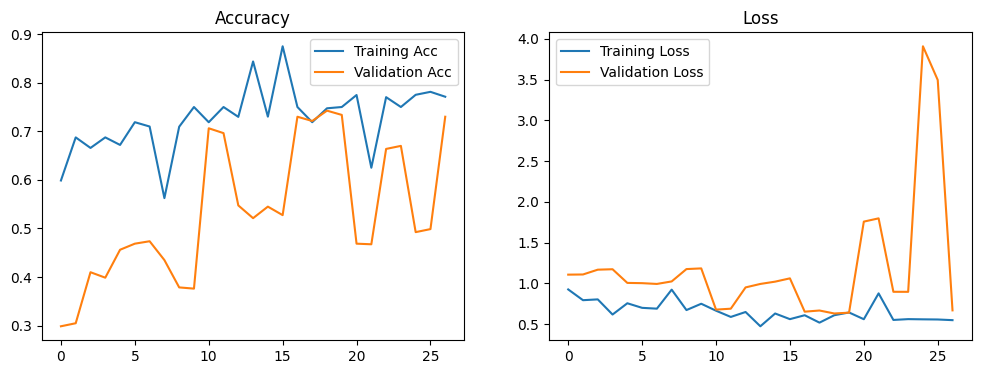

In [7]:
# --- 6. EVALUASI MODEL (METRICS) ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


--- Memulai Analisis Error ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


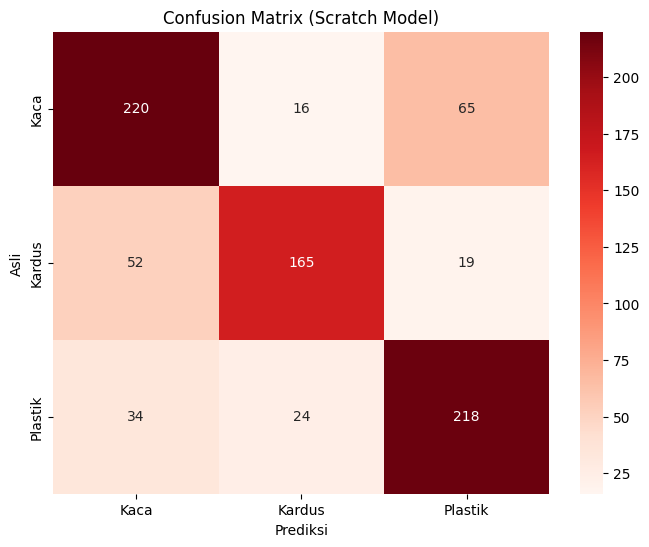


--- Detail Performa per Kelas ---
              precision    recall  f1-score   support

        Kaca       0.72      0.73      0.72       301
      Kardus       0.80      0.70      0.75       236
     Plastik       0.72      0.79      0.75       276

    accuracy                           0.74       813
   macro avg       0.75      0.74      0.74       813
weighted avg       0.74      0.74      0.74       813


Menampilkan sampel kesalahan (210 total error found)...


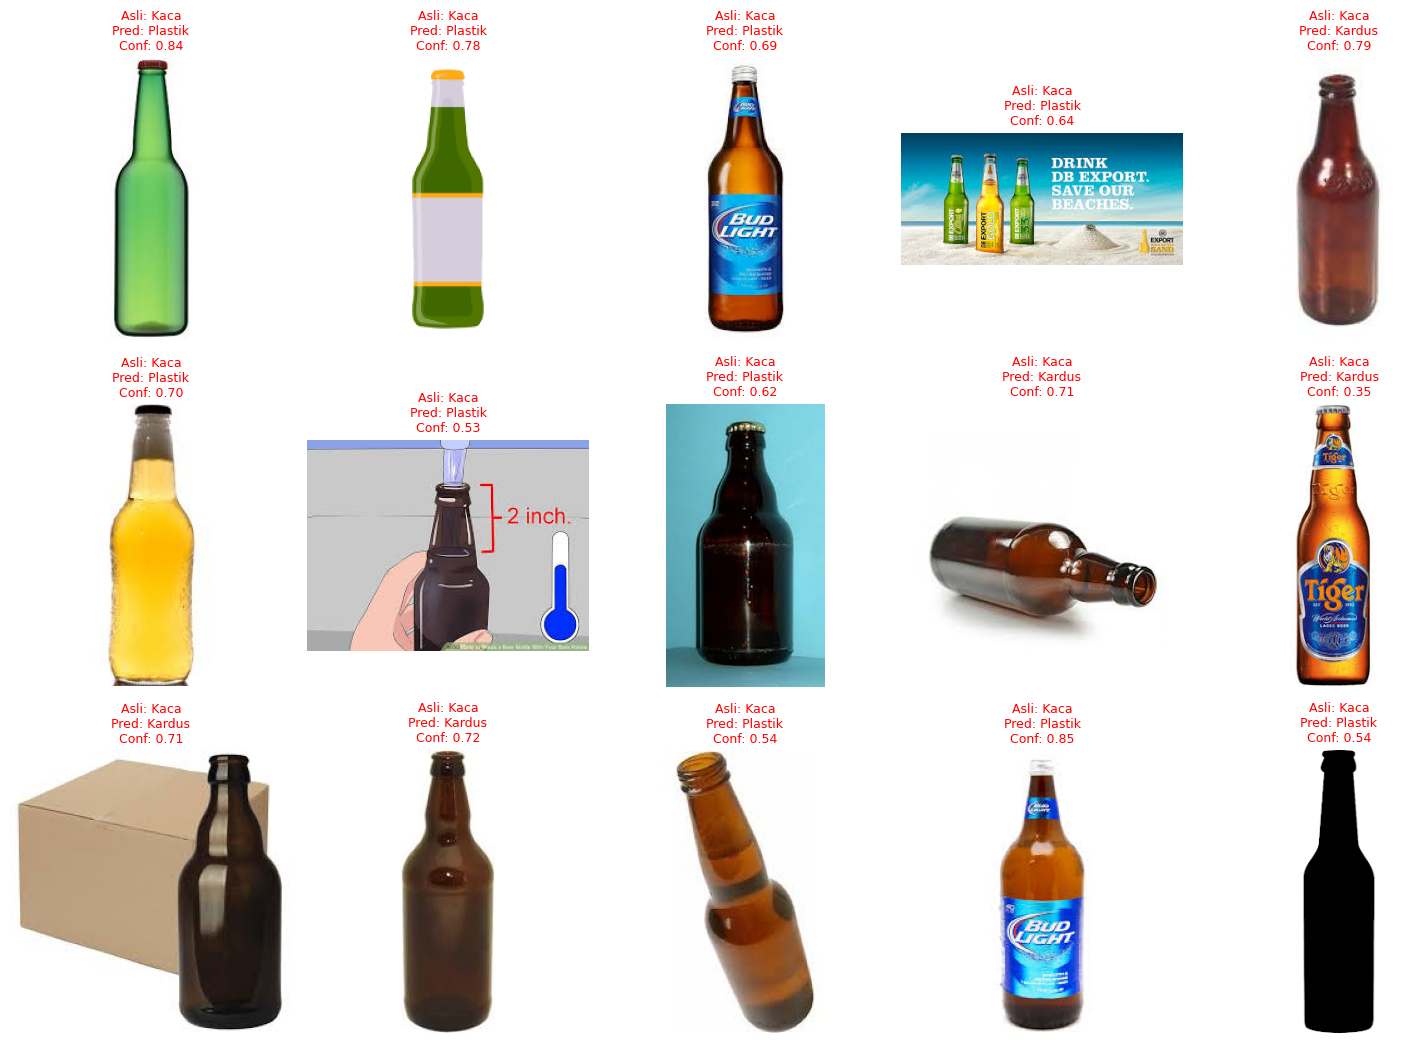

In [9]:
# --- 7. DEBUGGING & ERROR ANALYSIS (VISUALISASI) ---
print("\n--- Memulai Analisis Error ---")

# A. Reset & Prediksi
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred_indices = np.argmax(Y_pred, axis=1)
y_true_indices = validation_generator.classes
filenames = validation_generator.filenames

# B. Confusion Matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediksi')
plt.ylabel('Asli')
plt.title('Confusion Matrix (Scratch Model)')
plt.show()

# C. Classification Report
print("\n--- Detail Performa per Kelas ---")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

# D. Galeri Kesalahan (Error Gallery)
errors = np.where(y_pred_indices != y_true_indices)[0]
print(f"\nMenampilkan sampel kesalahan ({len(errors)} total error found)...")

if len(errors) > 0:
    # Tampilkan max 15 gambar error
    display_indices = errors[:15]
    rows = (len(display_indices) // 5) + 1
    plt.figure(figsize=(15, 3.5 * rows))

    for i, idx in enumerate(display_indices):
        path = os.path.join(PATH_VALIDATION, filenames[idx])
        img = mpimg.imread(path)

        true_lbl = class_labels[y_true_indices[idx]]
        pred_lbl = class_labels[y_pred_indices[idx]]
        conf = Y_pred[idx][y_pred_indices[idx]]

        plt.subplot(rows, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Asli: {true_lbl}\nPred: {pred_lbl}\nConf: {conf:.2f}", color='red', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("Sempurna! Tidak ada kesalahan pada data validasi.")